In [1]:
#    es mejor desde powershell: python -m pip install spei
import pandas as pd
import numpy as np
import os
import spei as si
from spei import spi, spei

In [2]:
# --- CONFIGURACIÓN DE RUTAS ---
PATH_ENTRADA = "../01_DATA/for_indices" # Donde están tus 112 CSVs
PATH_SALIDA = "../02_OUTPUTS"

def procesar_indices_jalisco(ventana=3):
    archivos = [f for f in os.listdir(PATH_ENTRADA) if f.endswith('.csv')]
    print(f"Calculando SPI y SPEI para ventana de {ventana} meses...")

    for archivo in archivos:
        try:
            # 1. Cargar datos
            df = pd.read_csv(os.path.join(PATH_ENTRADA, archivo), 
                             index_col='FECHA', parse_dates=True)
            
            # 2. Agregación Mensual
            # Sumamos Precipitación y Evaporación, promediamos temperaturas
            mensual = pd.DataFrame()
            mensual['PRECIP'] = df['PRECIP'].resample('MS').sum()
            mensual['EVAP'] = df['EVAP'].resample('MS').sum()
            
            # Aplicamos tu criterio de calidad (>5 días faltantes = mes NaN)
            dias_nan = df['PRECIP'].isna().resample('MS').sum()
            mensual.loc[dias_nan > 5, 'PRECIP'] = np.nan
            
            # 3. Cálculo del Balance (D) para el SPEI
            # El SPEI se basa en la diferencia entre lo que cae y lo que se evapora
            mensual['D'] = mensual['PRECIP'] - mensual['EVAP']

            # 4. Acumulación por ventana (Suma móvil)
            # PASO CRUCIAL: La librería ahora requiere los datos ya acumulados
            precip_acum = mensual['PRECIP'].rolling(window=ventana).sum().dropna()
            balance_acum = mensual['D'].rolling(window=ventana).sum().dropna()

            # 5. Cálculo de Índices
            # SPI: Usa distribución Gamma por defecto
            # SPEI: Usa distribución Log-Logística por defecto
            val_spi = spi(precip_acum)
            val_spei = spei(balance_acum)

            # 6. Organizar y Guardar
            df_indices = pd.DataFrame(index=precip_acum.index)
            df_indices['SPI'] = val_spi
            df_indices['SPEI'] = val_spei
            
            nombre_out = f"RESULTADOS_V{ventana}_{archivo}"
            df_indices.to_csv(os.path.join(PATH_SALIDA, nombre_out))
            
        except Exception as e:
            print(f"Error en {archivo}: {e}")

    print(f"--- Proceso terminado para ventana {ventana} ---")

# Ejecutamos para 3 y 12 meses
procesar_indices_jalisco(ventana=3)
procesar_indices_jalisco(ventana=12)

Calculando SPI y SPEI para ventana de 3 meses...
--- Proceso terminado para ventana 3 ---
Calculando SPI y SPEI para ventana de 12 meses...
--- Proceso terminado para ventana 12 ---


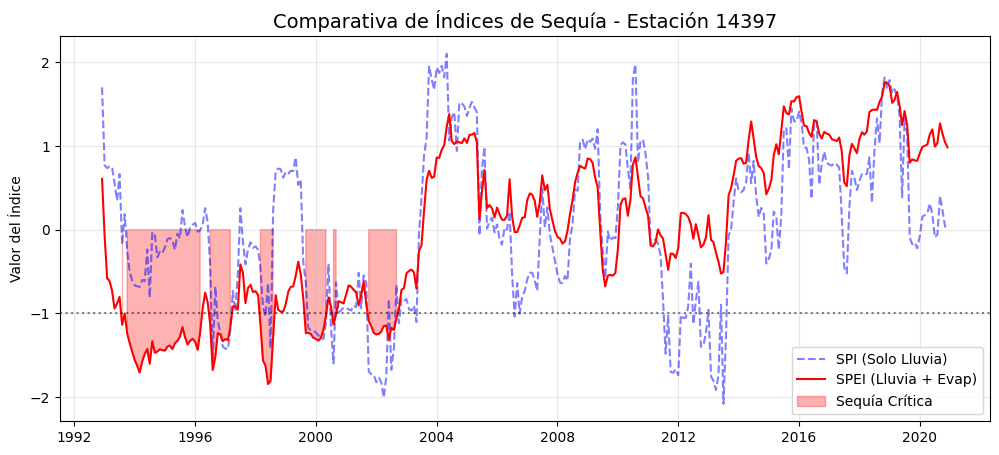

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def grafica_presentacion(file_path):
    df = pd.read_csv(file_path, index_col='FECHA', parse_dates=True)
    
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['SPI'], label='SPI (Solo Lluvia)', color='blue', alpha=0.5, linestyle='--')
    plt.plot(df.index, df['SPEI'], label='SPEI (Lluvia + Evap)', color='red', linewidth=1.5)
    
    plt.fill_between(df.index, df['SPEI'], 0, where=(df['SPEI'] < -1), color='red', alpha=0.3, label='Sequía Crítica')
    plt.axhline(-1, color='black', linestyle=':', alpha=0.5)
    plt.title(f"Comparativa de Índices de Sequía - Estación 14397", fontsize=14)
    plt.ylabel("Valor del Índice")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Usa uno de tus archivos generados
grafica_presentacion("../02_OUTPUTS/ven12/RESULTADOS_V12_SMN_14397_1991_2020.csv")